In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
file_path = 'resultados_secao_absolutos/EDUARDO_DA_COSTA_PAES.csv'
data = pd.read_csv(file_path, index_col=0)
name = file_path.split(r'/')[1].split('.')[0]

In [3]:
data.head(2)

,candidato,municipio,local,zona,secao,turno,votos_recebidos,ds_grau_escolaridade_ensino_médio_incompleto,ds_grau_escolaridade_superior_completo,ds_grau_escolaridade_ensino_fundamental_incompleto,...,ds_faixa_etaria_100_anos_ou_mais,ds_faixa_etaria_95_a_99_anos,ds_faixa_etaria_17_anos,ds_faixa_etaria_16_anos,ds_faixa_etaria_inválida,ds_genero_feminino,ds_genero_masculino,ds_genero_não_informado,eleitores_totais,percentual_votos
0,EDUARDO DA COSTA PAES,60011,1317,245,254,1,170,90,38,60,...,8,10,0,1,0,263,194,2,459,0.370370
1,EDUARDO DA COSTA PAES,60011,1341,123,262,1,155,70,18,100,...,10,11,0,0,0,239,186,0,425,0.364706


In [4]:
remove_cols = [col for col in data.columns if re.search('não_informado', col) or re.search('inválida', col)]
data = data.drop(remove_cols, axis=1)

In [5]:
pesos_escolaridade = {
    'ds_grau_escolaridade_analfabeto': 0,
    'ds_grau_escolaridade_lê_e_escreve': 1,
    'ds_grau_escolaridade_ensino_fundamental_incompleto': 2,
    'ds_grau_escolaridade_ensino_fundamental_completo': 3,
    'ds_grau_escolaridade_ensino_médio_incompleto': 4,
    'ds_grau_escolaridade_ensino_médio_completo': 5,
    'ds_grau_escolaridade_superior_incompleto': 6,
    'ds_grau_escolaridade_superior_completo': 7
}

# Calculando o score usando np.average com os pesos
data["escolaridade_score"] = data.apply(
    lambda row: np.average(
        [pesos_escolaridade[col] for col in pesos_escolaridade.keys()],  # Valores das colunas
        weights=[row[col] for col in pesos_escolaridade.keys()]  # Pesos associados às colunas
    ),
    axis=1
)

In [6]:
data = data.drop(pesos_escolaridade.keys(), axis=1)
data.head(1)

,candidato,municipio,local,zona,secao,turno,votos_recebidos,ds_raca_cor_parda,ds_raca_cor_branca,ds_raca_cor_preta,...,ds_faixa_etaria_90_a_94_anos,ds_faixa_etaria_100_anos_ou_mais,ds_faixa_etaria_95_a_99_anos,ds_faixa_etaria_17_anos,ds_faixa_etaria_16_anos,ds_genero_feminino,ds_genero_masculino,eleitores_totais,percentual_votos,escolaridade_score
0,EDUARDO DA COSTA PAES,60011,1317,245,254,1,170,6,15,4,...,4,8,10,0,1,263,194,459,0.37037,3.997802


In [7]:
def extrair_media_idade(col):
    try:
        return (float(col.split('_')[3]) + float(col.split('_')[5])) / 2
    except:
        try:
            return (float(col.split('_')[3]))
        except:
            return 0

In [8]:
etaria_cols = [col for col in data.columns if re.search('faixa_etaria', col)]
etaria_cols_weights = {
    col: extrair_media_idade(col)
    for col in etaria_cols
}

data['idade_score'] = data.apply(
    lambda row: np.average(
        [etaria_cols_weights[col] for col in etaria_cols_weights.keys()],
        weights=[row[col] for col in etaria_cols_weights.keys()]
    ),
    axis=1
)

In [9]:
data = data.drop(etaria_cols_weights.keys(), axis=1)
data.head(1)

,candidato,municipio,local,zona,secao,turno,votos_recebidos,ds_raca_cor_parda,ds_raca_cor_branca,ds_raca_cor_preta,ds_raca_cor_amarela,ds_raca_cor_indígena,ds_genero_feminino,ds_genero_masculino,eleitores_totais,percentual_votos,escolaridade_score,idade_score
0,EDUARDO DA COSTA PAES,60011,1317,245,254,1,170,6,15,4,0,0,263,194,459,0.37037,3.997802,52.913943


In [10]:
data[['percentual_votos', 'escolaridade_score', 'idade_score']].corr()

,percentual_votos,escolaridade_score,idade_score
percentual_votos,1.000000,-0.169261,-0.320469
escolaridade_score,-0.169261,1.000000,0.172643
idade_score,-0.320469,0.172643,1.000000


In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [12]:
data_filtered = data.loc[data['percentual_votos'] < 1]

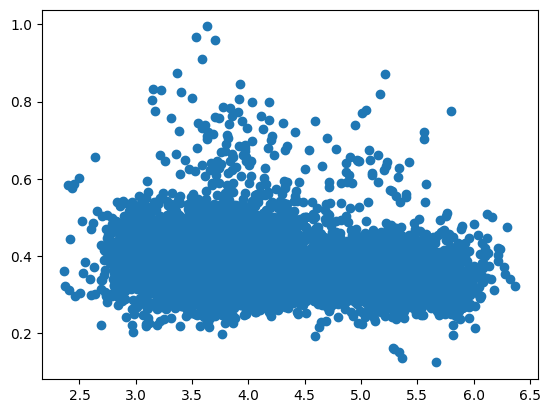

In [13]:
x = data_filtered['escolaridade_score'].values
y = data_filtered['percentual_votos'].values
plt.scatter(x,y)

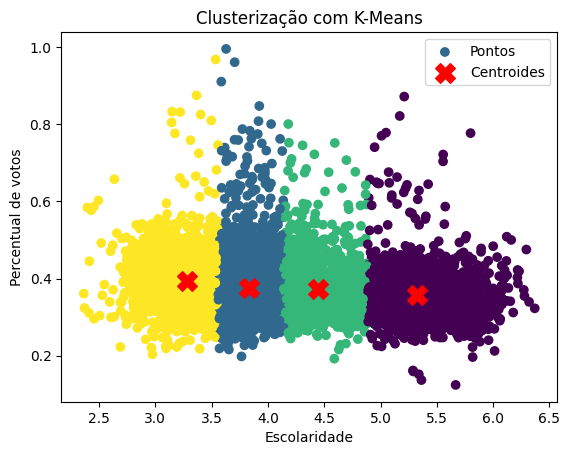

In [14]:
X = np.column_stack((x, y))
# 2. Aplicar K-Means
kmeans = KMeans(n_clusters=4, random_state=42)  # Configurar para 3 clusters
kmeans.fit(X)

# Obter os resultados
labels = kmeans.labels_           # Rótulos para cada ponto
centroids = kmeans.cluster_centers_  # Coordenadas dos centróides

# 3. Visualizar os resultados
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', label='Pontos')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroides')
plt.title('Clusterização com K-Means')
plt.xlabel('Escolaridade')
plt.ylabel('Percentual de votos')
plt.legend()
plt.show()

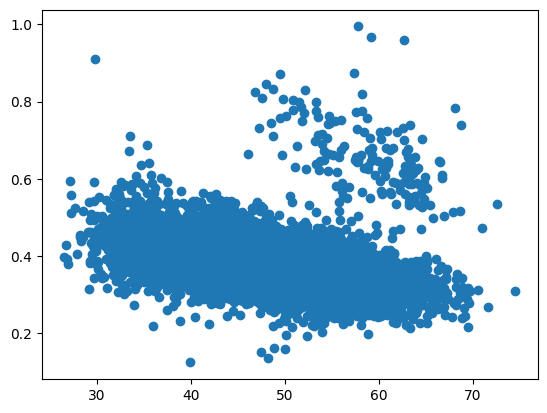

In [15]:
x = data_filtered['idade_score'].values
plt.scatter(x,y)

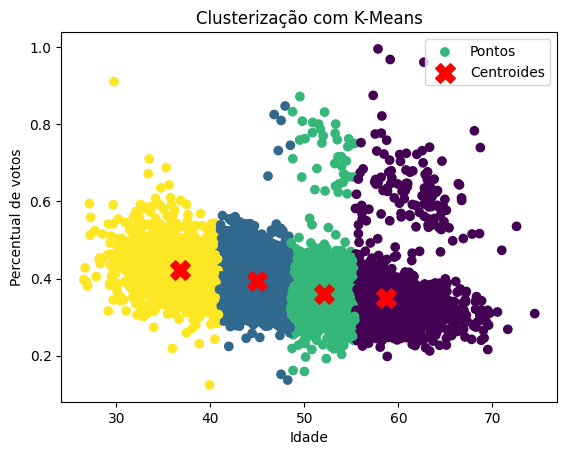

In [16]:
X = np.column_stack((x, y))
# 2. Aplicar K-Means
kmeans = KMeans(n_clusters=4, random_state=42)  # Configurar para 3 clusters
kmeans.fit(X)

# Obter os resultados
labels = kmeans.labels_           # Rótulos para cada ponto
centroids = kmeans.cluster_centers_  # Coordenadas dos centróides

# 3. Visualizar os resultados
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', label='Pontos')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroides')
plt.title('Clusterização com K-Means')
plt.xlabel('Idade')
plt.ylabel('Percentual de votos')
plt.legend()
plt.show()

In [17]:
from scipy.stats import binom

# Probabilidade genérica
p = data['votos_recebidos'].sum()/data['eleitores_totais'].sum()

# Calcula a probabilidade para quantidade de votos recebidos
data['probabilidade'] = binom.pmf(k = data['votos_recebidos'], n = data['eleitores_totais'], p = p)

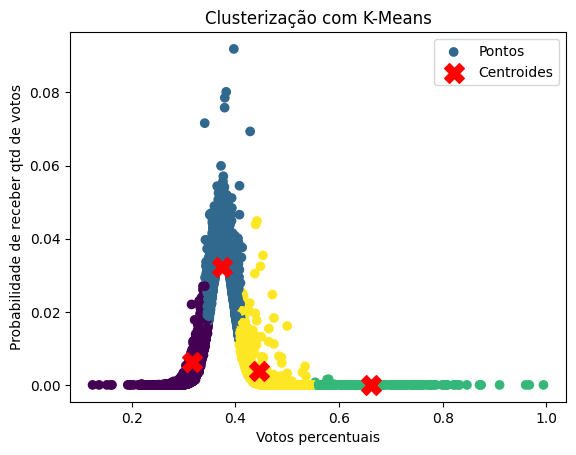

In [18]:
data_filtered = data.loc[data['percentual_votos'] < 1]
X = data_filtered[['percentual_votos', 'probabilidade']].values
# 2. Aplicar K-Means
kmeans = KMeans(n_clusters=4, random_state=42)  # Configurar para 3 clusters
kmeans.fit(X)

# Obter os resultados
labels = kmeans.labels_           # Rótulos para cada ponto
centroids = kmeans.cluster_centers_  # Coordenadas dos centróides

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', label='Pontos')  # Usar X para as dimensões
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroides')
plt.title('Clusterização com K-Means')
plt.xlabel('Votos percentuais')
plt.ylabel('Probabilidade de receber qtd de votos')
plt.legend()
plt.show()

In [19]:
data_filtered['clusters'] = labels
data_filtered.head()

C:\Users\ciaon\AppData\Local\Temp\ipykernel_4472\2726077203.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['clusters'] = labels


,candidato,municipio,local,zona,secao,turno,votos_recebidos,ds_raca_cor_parda,ds_raca_cor_branca,ds_raca_cor_preta,ds_raca_cor_amarela,ds_raca_cor_indígena,ds_genero_feminino,ds_genero_masculino,eleitores_totais,percentual_votos,escolaridade_score,idade_score,probabilidade,clusters
0,EDUARDO DA COSTA PAES,60011,1317,245,254,1,170,6,15,4,0,0,263,194,459,0.370370,3.997802,52.913943,0.037699,1
1,EDUARDO DA COSTA PAES,60011,1341,123,262,1,155,14,5,10,0,0,239,186,425,0.364706,3.531765,58.080000,0.036410,1
2,EDUARDO DA COSTA PAES,60011,1244,245,192,1,179,18,11,4,0,0,271,220,491,0.364562,4.250509,43.278004,0.033260,1
3,EDUARDO DA COSTA PAES,60011,1694,25,575,1,161,16,8,6,0,0,226,185,412,0.390777,3.321168,52.441748,0.032480,1
4,EDUARDO DA COSTA PAES,60011,1236,161,173,1,160,0,0,0,0,0,267,205,472,0.338983,3.084746,39.627119,0.010229,0


In [20]:
cluster_data = data_filtered.groupby('clusters').agg(
    percentual_votos = ('percentual_votos', 'mean'),
    prob_mean = ('probabilidade', 'mean'),
    qtd = ('probabilidade', 'size')
).sort_values('percentual_votos', ascending=False)
cluster_data

,percentual_votos,prob_mean,qtd
clusters,,,
2,0.661210,0.000024,177
3,0.445445,0.003813,2534
1,0.374970,0.032244,5618
0,0.316790,0.006183,3860


### Conclusões
- Cluster 1: percentual de votos com maior probabilidade de ocorrer
- Cluster 2 e 3: percentual de votos altos improváveis (cases de sucesso)
- Cluster 0: percentual de votos baixos improváveis (case de fracasso)

In [21]:
import tse
import folium
from folium.plugins import MarkerCluster

In [22]:
analise = tse.TseAnalysis(
    database={
        'path': 'databases/eleicoes_2024.sql',
        'alias': 'geral' 
    }
)

In [23]:
analise.attach_database([])

Bancos carregados:
0) main
-path: d:\projects\tse-data\databases\eleicoes_2024.sql
--tables: 
-- locais
-----
2) geral
-path: d:\projects\tse-data\databases\eleicoes_2024.sql
--tables: 
-- locais
-----


In [24]:
cd_municipio = data_filtered['municipio'].values[0]
cd_municipio

60011

In [25]:
query = f"""
    SELECT
        CD_MUNICIPIO as municipio,
        NR_ZONA as zona,
        NR_SECAO as secao,
        NR_LOCAL_VOTACAO as local,
        NR_LATITUDE as latitude,
        NR_LONGITUDE as longitude
    FROM
        geral.locais
    WHERE
        CD_MUNICIPIO = '{cd_municipio}'
"""

In [26]:
locais_data = pd.read_sql_query(query, analise.conn)

In [27]:
locais_data.head(1)

,municipio,zona,secao,local,latitude,longitude
0,60011,185,136,1252,-22.890469,-43.355049


In [28]:
data_filtered.head(1)

,candidato,municipio,local,zona,secao,turno,votos_recebidos,ds_raca_cor_parda,ds_raca_cor_branca,ds_raca_cor_preta,ds_raca_cor_amarela,ds_raca_cor_indígena,ds_genero_feminino,ds_genero_masculino,eleitores_totais,percentual_votos,escolaridade_score,idade_score,probabilidade,clusters
0,EDUARDO DA COSTA PAES,60011,1317,245,254,1,170,6,15,4,0,0,263,194,459,0.37037,3.997802,52.913943,0.037699,1


In [29]:
data_filtered = pd.merge(
    data_filtered,
    locais_data,
    how='inner',
    on=['municipio','zona', 'secao', 'local']   
)

In [30]:
data_filtered.head()

,candidato,municipio,local,zona,secao,turno,votos_recebidos,ds_raca_cor_parda,ds_raca_cor_branca,ds_raca_cor_preta,...,ds_genero_feminino,ds_genero_masculino,eleitores_totais,percentual_votos,escolaridade_score,idade_score,probabilidade,clusters,latitude,longitude
0,EDUARDO DA COSTA PAES,60011,1317,245,254,1,170,6,15,4,...,263,194,459,0.370370,3.997802,52.913943,0.037699,1,-22.890643,-43.563465
1,EDUARDO DA COSTA PAES,60011,1341,123,262,1,155,14,5,10,...,239,186,425,0.364706,3.531765,58.080000,0.036410,1,-22.867606,-43.430114
2,EDUARDO DA COSTA PAES,60011,1244,245,192,1,179,18,11,4,...,271,220,491,0.364562,4.250509,43.278004,0.033260,1,-22.877551,-43.564265
3,EDUARDO DA COSTA PAES,60011,1694,25,575,1,161,16,8,6,...,226,185,412,0.390777,3.321168,52.441748,0.032480,1,-22.975289,-43.694287
4,EDUARDO DA COSTA PAES,60011,1236,161,173,1,160,0,0,0,...,267,205,472,0.338983,3.084746,39.627119,0.010229,0,-22.861977,-43.248238


In [31]:
cluster_map_data = data_filtered[['clusters', 'latitude', 'longitude']]

In [32]:
cluster_map_data.head(1)

,clusters,latitude,longitude
0,1,-22.890643,-43.563465


In [37]:
# Criando um mapa centrado
m = folium.Map(location=[
    cluster_map_data['latitude'].mean(), 
    cluster_map_data['longitude'].mean()], zoom_start=15)

# Paleta de cores para clusters
colors = {0: 'purple', 1: 'blue', 2: 'green', 3: 'yellow'}
legenda = {
    0: 'abaixo do esperado',
    1: 'esperado',
    2: 'muito acima do esperado',
    3: 'acima do esperado'
}
# Criando camadas separadas por cluster
for cluster_id, group in cluster_map_data.groupby('clusters'):
    cluster_layer = folium.FeatureGroup(name=f'Apoio {legenda.get(cluster_id)}')
    for _, row in group.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=10,
            color=colors[cluster_id],
            fill=True,
            fill_color=colors[cluster_id],
            fill_opacity=0.7,
            popup=f"Cluster: {row['clusters']}"
        ).add_to(cluster_layer)
    cluster_layer.add_to(m)

In [38]:
legend_html = """
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 250px; height: 150px;
            background-color: white; z-index: 1000; font-size: 14px;
            border: 2px solid grey; border-radius: 10px; padding: 10px;">
    <b>Legenda</b><br>
    <i style="background:purple; width:10px; height:10px; display:inline-block; margin-right:5px;"></i> Apoio abaixo do esperado<br>
    <i style="background:blue; width:10px; height:10px; display:inline-block; margin-right:5px;"></i> Apoio esperado<br>
    <i style="background:yellow; width:10px; height:10px; display:inline-block; margin-right:5px;"></i> Apoio acima do esperado<br>
    <i style="background:green; width:10px; height:10px; display:inline-block; margin-right:5px;"></i> Apoio muito acima do esperado<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

In [39]:
# Adicionando o controle de camadas
folium.LayerControl().add_to(m)

In [40]:
m.save(f"mapas/apoio_{name}.html")